# 1. Dataset Preprocessing

**Goal**: ingest PGN games, extract every FEN position and deduplicate, store them in SQLite, evaluate positions with Stockfish, then assign classification labels.

## Key components
- `iter_games(pgn_path)` - stream PGN games from disk.
- `pgn_to_db(folder, cursor, conn)` - populate the `positions` table with unique FENs.
- `Engine(path)` - lightweight wrapper to evaluate fens via Stockfish engine.
- `evaluate_fen(fen, engine, depth)` - evaluate one position and print results.
- `evaluate_and_update_fen_in_db(fen_id, fen, engine, cursor, depth)` - score and label one database row, then persist.

## Database schema
`positions(id INTEGER PRIMARY KEY, fen TEXT UNIQUE NOT NULL, stockfish_score REAL, label TEXT)`

- `fen`, unique board state.
- `stockfish_score`, centipawns from White’s point of view.
- `label`, categorical class derived from the score.

## Labeling scheme (centipawns → label)
| Range (cp)            | Label               |
|-----------------------|---------------------|
| cp ≥ +500             | White winning       |
| +500 > cp ≥ +300      | White decisive      |
| +300 > cp ≥ +100      | White better        |
| +100 > cp > −100      | Equal               |
| −100 ≥ cp > −300      | Black better        |
| −300 > cp ≥ −500      | Black decisive      |
| cp ≤ −500             | Black winning       |

## Inputs
- A folder containing `.pgn` files.
- A path to a Stockfish executable compatible with your CPU.

## Outputs
- `positions.db`, an SQLite file with all positions, scores, and labels.

## How to use
1. Put your PGN files in the configured folder.
2. Set `stockfish_executable_path` to your Stockfish binary.
3. Run the cells from top to bottom to populate the database, then run the evaluation pass.

In [2]:
from pathlib import Path
from typing import Dict, Iterator, Optional, Any
from enum import Enum
import sys, asyncio
import chess
import chess.pgn
import chess.engine

In [26]:
if sys.platform.startswith("win"):
    stockfish_executable_path = Path("./stockfish/stockfish-windows-x86-64-avx2.exe")
    print(f"Using Stockfish executable: {stockfish_executable_path}")

if sys.platform.startswith("darwin"):
    stockfish_executable_path = Path("./stockfish/stockfish-macos-m1-apple-silicon")
    print(f"Using Stockfish executable: {stockfish_executable_path}")

Using Stockfish executable: stockfish/stockfish-macos-m1-apple-silicon


In [3]:
def iter_games(pgn_path: Path) -> Iterator[chess.pgn.Game]:
    """Yield games one by one from a PGN file"""
    
    if pgn_path.suffix.lower() != ".pgn":
        raise ValueError(f"Expected a .pgn file, got: {pgn_path.suffix}")
    
    with open(pgn_path, "r", encoding="utf-8", errors="replace") as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            yield game

In [4]:
def pgn_to_db(chess_games_folder: Path, c, conn):
    """Read PGN files and insert FEN positions into the database"""       

    for pgn_file in chess_games_folder.iterdir():
        for game in iter_games(pgn_file):
            board = game.board()
            fen = board.fen()
            c.execute("INSERT OR IGNORE INTO positions (fen) VALUES (?)", (fen,))

            for move in game.mainline_moves():
                try:
                    board.push(move)
                    fen = board.fen()
                    c.execute("INSERT OR IGNORE INTO positions (fen) VALUES (?)", (fen,))
                except ValueError as e:
                    print(f"Skipping illegal move in {pgn_file}:{e}")            

    conn.commit()

    c.execute("SELECT COUNT(*) from positions")
    total = c.fetchone()[0]
    print(f"{total} positions loaded.")

In [5]:
import sqlite3

conn = sqlite3.connect("positions.db")

c = conn.cursor()

c.execute("""
          CREATE TABLE IF NOT EXISTS positions (
          id INTEGER PRIMARY KEY,
          fen TEXT UNIQUE NOT NULL,
          stockfish_score REAL,
          label TEXT
        )
""")

conn.commit()

chess_games_folder = Path("./chess_games_sample")
pgn_to_db(chess_games_folder, c, conn)

conn.close()

2933 positions loaded.


In [8]:
"""
Why this cell exists:
- python-chess launches Stockfish via asyncio.subprocess_exec.
- On Windows, the Selector event loop cannot create subprocesses, it raises NotImplementedError.
- Some Jupyter kernels on Windows start with the Selector policy by default.
- Switching to WindowsProactorEventLoopPolicy enables subprocess support in this notebook.

How to use:
- Run this cell once before creating the engine.
- On macOS or Linux this does nothing and is safe.
"""
if sys.platform.startswith("win"):
    print(f"Initial Policy: {type(asyncio.get_event_loop_policy()).__name__}")
    asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())
    print(f"New Policy: {type(asyncio.get_event_loop_policy()).__name__}")


In [14]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [15]:
class Engine:
    def __init__(self, path: Path):
        self.engine = chess.engine.SimpleEngine.popen_uci(str(path))
        print("Engine started.")
    
    def quit(self):
        self.engine.quit()
        print("Engine quit cleanly.")

    def get_centipawn_score(self, fen: str, depth: int) -> int:
        """Gives centipawn score for a fen string"""
        
        board = chess.Board(fen)
        info = self.engine.analyse(board=board, limit=chess.engine.Limit(depth=depth))
        
        # If there is a forced mate, score is very large
        score = info.get("score")
        if score is not None:
            centipawn_score = score.pov(chess.WHITE).score(mate_score=100000)

        return centipawn_score
    
    def classify_centipawn_score(self, cp: int) -> PositionLabel:
        """
        Classify a centipawn evaluation into a categorical label.
        
        To get the numerical representation of a PositionLabel, use the .value attribute.

        Mapping (centipawns → label):
            cp >= +500        → White is winning
            +500 > cp >= +300 → White has a decisive advantage
            +300 > cp >= +100 → White is better
            +100 > cp > -100  → The position is equal
            -100 >= cp > -300 → Black is better
            -300 > cp >= -500 → Black has a decisive advantage
            cp <= -500        → Black is winning
        """

        if cp >= 500: return PositionLabel.WHITE_WINNING
        if 500 > cp >= 300: return PositionLabel.WHITE_DECISIVE
        if 300 > cp >= 100: return PositionLabel.WHITE_BETTER
        if 100 > cp > -100: return PositionLabel.EQUAL
        if -100 >= cp > -300: return PositionLabel.BLACK_BETTER
        if -300 > cp >= -500: return PositionLabel.BLACK_DECISIVE
        return PositionLabel.BLACK_WINNING

In [16]:
def evaluate_fen(fen: str, engine: Engine, depth:int ):    
    """
    Evaluate a single FEN string
    """
    board = chess.Board(fen)

    centipawn_score = engine.get_centipawn_score(fen=fen, depth=depth)
    classified_centipawn_score = engine.classify_centipawn_score(centipawn_score)

    print("Fen evaluated:", fen)
    print("Centipawn score:", centipawn_score)
    print("Classified Centipawn score:", classified_centipawn_score)
    print("Classified Centipawn Label:", classified_centipawn_score.value)

    return fen, centipawn_score, classified_centipawn_score, board

Engine started.
Fen evaluated: r2q1rk1/pp3pp1/2p3p1/b7/B2Pb1Q1/2P5/PP4PP/R1B2RK1 b - - 1 17
Centipawn score: -15
Classified Centipawn score: PositionLabel.EQUAL
Classified Centipawn Label: 3
Engine quit cleanly.


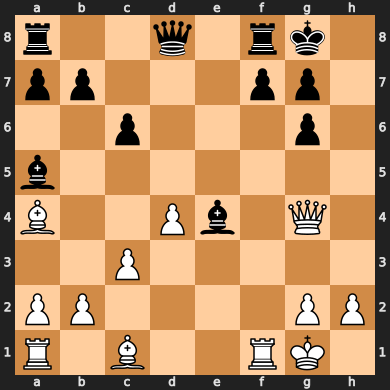

In [20]:
"""
Evaluates a fen string
"""

engine = Engine(stockfish_executable_path)

sample_fen = "r2q1rk1/pp3pp1/2p3p1/b7/B2Pb1Q1/2P5/PP4PP/R1B2RK1 b - - 1 17"

_, _, _, board = evaluate_fen(sample_fen, engine=engine, depth=30)
engine.quit()

board

In [21]:
def evaluate_and_update_fen_in_db(fen_id: int, fen:str, engine: Engine, c: sqlite3.Cursor, depth: int):
    """
    Evaluate and update a single FEN by database id
    """
    centipawn_score = engine.get_centipawn_score(fen=fen, depth=depth)
    classified_centipawn_score = engine.classify_centipawn_score(centipawn_score)

    c.execute(
        "UPDATE positions SET stockfish_score = ?, label = ? WHERE id = ?",
        (centipawn_score, classified_centipawn_score.value, fen_id)
    )
    return centipawn_score, classified_centipawn_score, classified_centipawn_score.value


In [29]:
from tqdm import tqdm

engine = Engine(stockfish_executable_path)

"""
Evaluate all rows that has not been evaluated before
Save everytime 100 rows has been evaluated
"""

batch_size = 100

with sqlite3.connect("positions.db") as conn:
    read_cursor = conn.cursor()
    write_cursor = conn.cursor()

    rows = read_cursor.execute("SELECT id, fen FROM positions WHERE stockfish_score IS NULL ORDER BY id").fetchall() 
    total_rows=len(rows)

    processed_rows = 0

    for row_id, fen in tqdm(rows, total=total_rows, desc="Labelling", unit="row"):
        evaluate_and_update_fen_in_db(fen_id=row_id, fen=fen, engine=engine, c=write_cursor, depth=10)
        processed_rows += 1
        if processed_rows % batch_size == 0:
            conn.commit()

    conn.commit()  

engine.quit()

Engine started.


Labelling: 100%|██████████| 2933/2933 [00:26<00:00, 109.94row/s]

Engine quit cleanly.


In [28]:
def wipe_database_evaluations():
    confirm = input("Type 'CONFIRM' to wipe all evaluations: ")
    if confirm.upper() == "CONFIRM":
        with sqlite3.connect("positions.db") as conn:
            c = conn.cursor()
            c.execute("UPDATE positions SET stockfish_score = NULL, label = NULL")
            conn.commit()
        print("All evaluations wiped.")
    else:
        print("Aborted. Nothing changed.")
    
wipe_database_evaluations()

All evaluations wiped.
